##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multi-spectral remote sensing with Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/multi_spectral_remote_sensing.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this notebook, you'll learn how to use Gemini's image understanding capabilities for multi-spectral analysis and remote sensing.

### What is remote sensing?

Remote sensing is the process of acquiring information about an object or area without making physical contact with it. It's essentially "seeing" and measuring something from a distance.

The most common form of remote sensing involves using sensors on satellites to collect data about the Earth's surface. Having a record of images of the Earth's surface across time enables us to track changes like: Where are forests disappearing? Where are fires occurring? And answer questions like: Are the crops in this field healthy? What is the solar potential of this roof? All of these questions (and more!) can be answered with the help of satellite data.

Much of the power of these satellite images lies in their ability to capture multi-spectral data. Instead of the 3 RGB bands you're used to, these satellites can capture data across many different bands of the electromagnetic spectrum, including those humans can't see, like Near-Infrared (NIR) and Short-Wave Infrared (SWIR). Certain wavelengths are beneficial for certain use cases, for example:

* **Vegetation Health**: Healthy plants reflect a lot of NIR light. By looking at the NIR band, you can assess crop health or monitor deforestation far more accurately than with a simple green photo.
* **Water Detection**: Water absorbs infrared light, making it easy to distinguish from land, map floodplains, or even analyze water quality.
* **Burn Scars**: SWIR bands are excellent at piercing through smoke and identifying recently burned areas after a wildfire.
* **Material Identification**: Different minerals and man-made materials have unique spectral "fingerprints," allowing you to identify them from space.

Mulitmodal foundation models like Gemini are trained to understand RGB images and not all of these other possible spectral bands. However, by mapping other parts of the electromagnetic spectrum to the RGB space and providing domain-specific instructions, you can leverage Gemini's understanding of the visual space for zero-shot prompting of multi-spectral images.

In this notebook you'll learn how to leverage these generalist multimodal models for specialized tasks without additional training or fine-tuning.

This notebook is based off of the paper from Google DeepMind and Google Research, [*Zero-Shot Multi-Spectral Learning: Reimagining a Generalist Multimodal Gemini 2.5 Model for Remote Sensing Applications*](https://arxiv.org/pdf/2509.19087)

## Setup

### Install SDK

In [1]:
%pip install -U -q "google-genai>=1.0.0"  # Install the Python SDK

# Always set at least 1.0.0 as the minimal version as there were breaking
# changes through the previous versions
# Of course, if your notebook uses a new feature and needs a more recent
# version, set the right minimum version to indicate when the feature was
# introduced.
# Always test your notebook with that fixed version (eg. '==1.0.0') to make.
# sure it's really the minimum version.


### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GEMINI_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) quickstart for an example.

In [2]:
from google.colab import userdata
from google import genai

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

For this notebook, use Gemini 2.5 Pro.

In [3]:
MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

## Remote sensing with RGB images

First, test Gemini's abilitiy to interpret satellite data with an RGB only image.

Here is an image of a forest taken with the [satellite Sentinel 2](https://colab.research.google.com/drive/1d-5VhuBn-s8cMCZu5xNi5Kl0vHxIiGms?resourcekey=0-lGdXpPdLgoID90O4AtdYzA#scrollTo=BzwUFUBXcSJV&line=1&uniqifier=1).

In [48]:
from IPython.display import display, Markdown, Image

In [60]:
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest.png -O forest.png

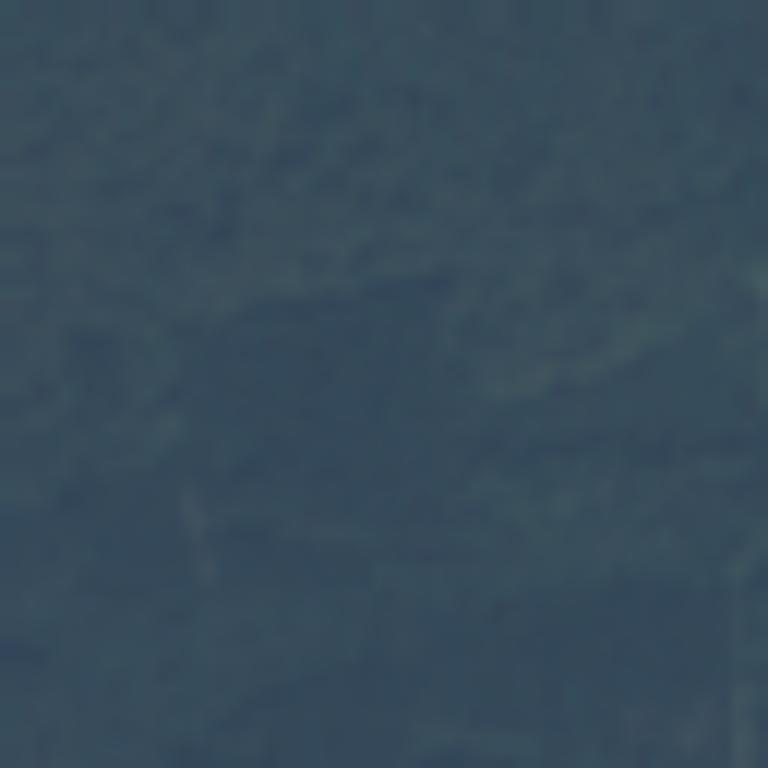

In [61]:
display(Image('forest.png', width=200))

Next, prompt Gemini to classify this image.

In [35]:
prompt = """
Classify this image as one of the following categories:
AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake.
"""

In [36]:
from google.genai import types

with open('forest.png', 'rb') as f:
  image_bytes = f.read()

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
        data=image_bytes,
        mime_type='image/png',
        ),
        prompt
        ]
    )

Markdown(response.text)

Based on the visual information provided, the image is best classified as **SeaLake**.

**Reasoning:**

The image displays a large, uniform area of a dark, muted blue-green color. This appearance is highly characteristic of a large body of water like a sea or a lake, especially when viewed from an aerial or satellite perspective. The subtle texture and color variations are consistent with the surface of water. None of the other categories, such as Forest, Residential, or AnnualCrop, would typically present as such a vast, homogenous blue-toned expanse.

Gemini incorrectly predicts that this image is a `SeaLake`, reasoning about the blue/green areas. The model is missing the critical multi-spectral data needed to make an accurate prediction.

## Remote sensing with multi-spectral images

To perform zero shot multi-spectral remote sensing with Gemini you need to:

1. Transform multi-spectral inputs to psudo image space.
2. Create a prompt which scientifically describes what the new inputs represent.

To see this process in action, you'll add five additional images to the prompt. These images include information about Sentinel 2's other spectral bands.


### Download images

Download the images from a public Cloud Storage bucket for viewing.

In [62]:
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest_0.jpeg -O forest_0.jpeg
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest_1.jpeg -O forest_1.jpeg
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest_2.jpeg -O forest_2.jpeg
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest_3.jpeg -O forest_3.jpeg
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest_4.jpeg -O forest_4.jpeg
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/forest_5.jpeg -O forest_5.jpeg

image_0 is the RGB image from the previous section.

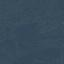

In [63]:
display(Image('forest_0.jpeg', width=200))

Images 1-5 represent combinations of different spectral bands. You can see that these band combinations reveal new features that were not visible in the RGB image.

multi-spectral images


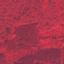

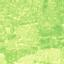

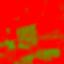

In [65]:
print('multi-spectral images')
display(Image('forest_1.jpeg', width=200))
display(Image('forest_2.jpeg', width=200))
display(Image('forest_4.jpeg', width=200))

### Create multi-spectral prompt

In addition to the multi-spectral images, you'll provide Gemini with domain specific information about how each of these new images was created.

In [40]:
multispectral_prompt = """
Instructions: Answer the question asked after the given 6 images of the same scene.
The images are generated by selecting different bands of the Sentinel-2 satellite.
The band information is as follows:
1. B02: Blue band at 10-meter resolution
2. B03: Green band at 10-meter resolution
3. B04: Red band at 10-meter resolution
4. B05: Red edge band (Central wavelength of 704.1 nm) at 20-meter resolution
5. B06: Red edge band (Central wavelength of 740.5 nm) at 20-meter resolution
6. B07: Red edge band (Central wavelength of 782.8 nm) at 20-meter resolution
7. B08: NIR band at 10-meter resolution
8. B8A: Narrow NIR band at 20-meter resolution
9. B01: Costal Aerosol band at 60-meter resolution
10. B09: Water vapor band at 60-meter resolution
11. B11: SWIR band (Central wavelength 1613.7 nm) at 20-meter resolution
12. B12: SWIR band (Central wavelength 2202.4 nm) at 20-meter resolution.
The first image is the RGB image generated using B04, B03 and B02 bands.
The second image is the False Color Composite image generated using B08, B04 and B03 bands.
The third image is the NDVI image which is a colormap with values Red, Yellow and Green
generated using B08 and B04 bands.
The fourth image is NDWI image whose values are in the range of -0.8 to 0.8 and using
a color map varying linearly as [(1, 1, 1), (1, 1, 1), (0, 0, 1)].
The fifth and sixth images are the NDMI images generated using B8A and B11 or B12 bands
with the colormap varying linearly as [(1, 0, 0), (0, 1, 0), (0, 0, 1)].
Output format: Output the option numbers corresponding to the correct answer in the format
"(X)" where X is the correct number choice. In case of multiple correct
answers, output the answer choices in the same format separated by commas. For example,
if the correct answers are choices 1 and 3, output "(1),(3)". Only output the option
numbers in the above format and DO NOT OUTPUT the full answer text or any other extra words.
Question: To which of the following classes do the given images belong to? Select all that apply. Possible answer choices:
(1) AnnualCrop, (2) Forest, (3) HerbaceousVegetation, (4) Highway, (5) Industrial, (6) Pasture, (7) PermanentCrop, (8) Residential, (9) River, (10) SeaLake.
"""


Upload the images with the [Files API](https://ai.google.dev/gemini-api/docs/files) so they can be processed by Gemini.

In [42]:
image_0 = client.files.upload(file="forest_0.jpeg")
image_1 = client.files.upload(file="forest_1.jpeg")
image_2 = client.files.upload(file="forest_2.jpeg")
image_3 = client.files.upload(file="forest_3.jpeg")
image_4 = client.files.upload(file="forest_4.jpeg")
image_5 = client.files.upload(file="forest_5.jpeg")

In [46]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[image_0, image_1, image_2, image_3, image_4, image_5, multispectral_prompt])

print(response.text)

(2)


The model responds with (2), which corresponded to "Forest" in our prompt.

Equipped with the multi-spectral information, Gemini correctly classifies the image.

## Creating multi-spectral composite images

In the previous section you saw that adding multi-spectral data to your prompt can help Gemini to correctly classify satellite images.

In this section you'll learn how to create these multi-spectral images, and how you can create your own images based on the bands relevant to your domain, in two steps:

1. Select three spectral bands that are important for your specific problem.

2. Scale the data from each band to a standard 0-255 integer range and assign them to Red, Green and Blue channels of a new image.

First, download the multi-spectral data for the forest image.

In [51]:
!wget -q https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/images/remote-sensing/download_fo_multi_spectral_bands.npy -O download_fo_multi_spectral_bands.npy

In [52]:
import numpy as np
s2_image = np.load('download_fo_multi_spectral_bands.npy')

In [53]:
print(s2_image.shape)

(64, 64, 13)


This forest satellite image is represented as a numpy array with shape (64,64,13), meaning there are 13 different spectral bands captured by the satellite. R, G, and B are 3 of these 13 bands. Each band is represented by a 64x64 matrix.

If you wanted to recreate the RGB image you plotted earlier, you would stack the RGB channels and end up with an array of size 64x64x3.

### Example multi-spectral image: NDVI

You are going to recreate image_2 which represents the Normalized Difference Vegetation Index (NDVI).

NDVI is a commonly used metric in remote sensing to quantify the amount, density, and health of vegetation in a given area. It works by measuring the unique way plants interact with specific wavelengths of light.

To calculate NDVI, you use the Red Light (Red) and Near-Infrared Light (NIR) bands. The formula is:

`(nir_band - red_band) / (nir_band + red_band)`

To do this calculation, you need to know the mapping of band names to indices in the numpy array. Then you can extract the Red and NIR bands. To see a full description of Sentinel band names and attributes refer to the [Sentinel 2 Earth Engine docs.](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED#bands)

In [54]:
band_name_to_index={
        "B01": 0,
        "B02": 1,
        "B03": 2,
        "B04": 3,
        "B05": 4,
        "B06": 5,
        "B07": 6,
        "B08": 7,
        "B8A": 8,
        "B09": 9,
        "B10": 10,
        "B11": 11,
        "B12": 12,
    }

red_band = s2_image[:, :, band_name_to_index['B04']]
nir_band = s2_image[:, :, band_name_to_index['B08']]

You can see that the Red and NIR bands are shape (64x64)

In [55]:
print(red_band.shape)
print(nir_band.shape)

(64, 64)
(64, 64)


The function below takes in the Red and NIR bands and calculates NDVI.

In [56]:
import matplotlib.pyplot as plt

def generate_ndvi_image(
    red_band: np.ndarray, nir_band: np.ndarray
) -> np.ndarray:
  """Generate an NDVI image from red and nir bands."""

  # calculate ndvi
  ndvi_image = (nir_band - red_band) / (nir_band + red_band)

  # map to rgb
  ndvi_image = plt.get_cmap('RdYlGn')(ndvi_image)

  # scale to 0-255
  ndvi_image = np.uint8(ndvi_image * 255)
  return ndvi_image

Let's walk through the steps of this function.

First, perform the NDVI calculation

`ndvi_image = (nir_band - red_band) / (nir_band + red_band)`

The `ndvi_image` at this point is a grayscale-like array where each pixel value is a floating-point number representing the NDVI score. While it has numerical meaning, it can't be viewed as a standard color image yet.

To make this information understandable by Gemini, you need to need to scale the data to a standard 0-255 integer range and assign them to Red, Green and Blue channels of a new image. This is known as color mapping.

`ndvi_image = plt.get_cmap('RdYlGn')(ndvi_image)`

The color mapping used here defines a spectrum where one end (Red) corresponds to the lowest values (e.g., −1.0), and the other end (Green) corresponds to the highest values (e.g., +1.0). When the colormap function is called with the ndvi_image array (`...('RdYlGn')(ndvi_image)`), it performs an element-wise lookup and conversion.

* Lowest NDVI scores (water, rock, or unhealthy plants) are assigned a Red or deep orange color.

* Mid-range scores are assigned Yellow.

* Highest NDVI scores (dense, healthy vegetation) are assigned a Green color.

In the next cell, you'll plot the colormapped image and you'll see it's mostly green (that makes sense since it's an image of a forest!)

Lastly, to prepare the image for display or saving in standard image formats (like PNG or JPEG), the floating-point values (0.0 to 1.0) are converted to the 0 to 255 integer range.

`ndvi_image = np.uint8(ndvi_image * 255)`

Now you can run the NDVI function to create the new composite image

In [57]:
ndvi_image = generate_ndvi_image(red_band, nir_band)

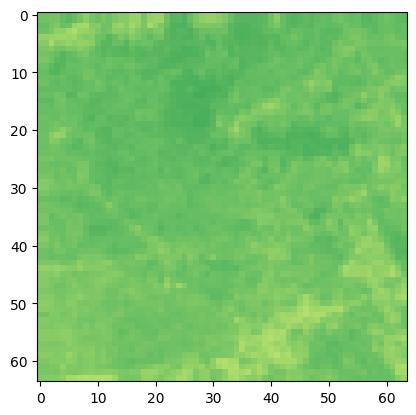

In [58]:
plt.imshow(ndvi_image)

By following this process of selecting relevant bands, and then color mapping them, you can inject multi-spectral information into your prompt and use Gemini for zero shot remote sensing.

# What's next


To learn more about how to use Gemini for remote sensing, [check out the original paper.](https://arxiv.org/pdf/2509.19087)